In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc
print(os.listdir("../input"))

from spacy.lang.en import English
from spacy.pipeline import DependencyParser
import spacy
from nltk import Tree
from category_encoders.one_hot import OneHotEncoder
from gensim.models import Word2Vec
import time

import numpy as np
from keras import backend
from keras import layers
from keras import models
from keras import initializers, regularizers, constraints, activations
from keras.engine import Layer
import keras.backend as K
from keras.layers import merge
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
import sklearn.metrics as skm

['gendered-pronoun-resolution', 'gap-data', 'gap-coreference', 'gap-coref-full-lbert']


Using TensorFlow backend.


In [2]:
def measure_log_loss(ground, preds):
    preds = preds.tolist()
    return skm.log_loss(ground, preds, labels=[0, 1, 2], eps=10**-15)

In [3]:
def add_results(df, probs):
    df.loc[:, 'A'] = pd.Series(probs[:, 0])
    df.loc[:, 'B'] = pd.Series(probs[:, 1])
    df.loc[:, 'NEITHER'] = pd.Series(probs[:, 2])
    
def drop_results(df):
    df.drop(columns=['A', 'B', 'NEITHER'], inplace=True)

 # Data Path

In [4]:
DATA_ROOT = '../input/'
GAP_DATA_FOLDER = os.path.join(DATA_ROOT, 'gap-data')

df_path1 = os.path.join(GAP_DATA_FOLDER, 'gap-phase1.csv')
df_path2 = os.path.join(GAP_DATA_FOLDER, 'gap-phase2.csv')

df = pd.read_csv(df_path1)
test_df = pd.read_csv(df_path2)

# split development data
dev_size = 454
dev_df = df.iloc[:dev_size]
train_df = df.iloc[dev_size:].reset_index()

# Clip Text

Set max length to 150 covers most of cases. Clip text where the token length longer than 150.

In [5]:
MAX_LEN = 150

In [6]:
def bs(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid + 1
    return lo

In [7]:
def clip_text(text, max_len, char_offset_p, char_offset_a, char_offset_b):
    doc = nlp(text)
    
    if len(doc) <= max_len:
        return text, 0
    
    token_lens = [token.idx for token in doc]
    char_offset_min = min(char_offset_p, char_offset_a, char_offset_b)
    char_offset_max = max(char_offset_p, char_offset_a, char_offset_b)
    
    # char offset to token offset
    mention_offset_min = bs(token_lens, char_offset_min) - 1
    mention_offset_max = bs(token_lens, char_offset_max) - 1
    
    if mention_offset_max - mention_offset_min + 1 > max_len:
        raise ValueError
    
    # make sure the mention is in the sentence span
    if mention_offset_max < max_len-1:
        hi = doc[max_len].idx
        return text[0:hi].strip(), 0
    else:
        len_span = mention_offset_max - mention_offset_min + 1
        hi_idx = min(int((max_len - len_span) / 2 + mention_offset_max + 1), len(doc))
        lo_idx = hi_idx - max_len
        text_append = text + " "
        return text_append[doc[lo_idx].idx: doc[hi_idx-1].idx + (doc[hi_idx-1].idx + len(doc[hi_idx-1]))].strip(), doc[lo_idx].idx
    
def text_clip_func(row, max_len):
    text, shift = clip_text(row['Text'], max_len, row['Pronoun-offset'], row['A-offset'], row['B-offset'])
    return pd.Series([text, shift], index=['Text', 'Shift'])

def text_clip_update(df, max_len):
    clip_info = df.apply(lambda row: text_clip_func(row, MAX_LEN), axis=1)
    df['Text'] = clip_info['Text']
    df['Pronoun-offset'] = df['Pronoun-offset'] - clip_info['Shift']
    df['A-offset'] = df['A-offset'] - clip_info['Shift']
    df['B-offset'] = df['B-offset'] - clip_info['Shift']

# Extra Features

In [8]:
num_pos_features = 45

In [9]:
def bs_(list_, target_):
    lo, hi = 0, len(list_) -1
    
    while lo < hi:
        mid = lo + int((hi - lo) / 2)
        
        if target_ < list_[mid]:
            hi = mid
        elif target_ > list_[mid]:
            lo = mid + 1
        else:
            return mid
    return lo

def ohe_dist(dist, buckets):
    idx = bs_(buckets, dist)
    oh = np.zeros(shape=(len(buckets),), dtype=np.float32)
    oh[idx] = 1
    
    return oh

def extrac_positional_features(text, char_offset1, char_offset2):
    doc = nlp(text)
    max_len = 64
    
    # char offset to token offset
    lens = [token.idx for token in doc]
    mention_offset1 = bs(lens, char_offset1) - 1
    mention_offset2 = bs(lens, char_offset2) - 1
    
    # token offset to sentence offset
    lens = [len(sent) for sent in doc.sents]
    acc_lens = [len_ for len_ in lens]
    pre_len = 0
    for i in range(0, len(acc_lens)):
        pre_len += acc_lens[i]
        acc_lens[i] = pre_len
    sent_index1 = bs(acc_lens, mention_offset1)
    sent_index2 = bs(acc_lens, mention_offset2)
    
    sent1 = list(doc.sents)[sent_index1]
    sent2 = list(doc.sents)[sent_index2]
    
    # buckets
    bucket_dist = [1, 2, 3, 4, 5, 8, 16, 32, 64]
    
    # relative distance
    dist = mention_offset2 - mention_offset1
    dist_oh = ohe_dist(dist, bucket_dist)
    
    # buckets
    bucket_pos = [0, 1, 2, 3, 4, 5, 8, 16, 32]
    
    # absolute position in the sentence
    sent_pos1 = mention_offset1 + 1
    if sent_index1 > 0:
        sent_pos1 = mention_offset1 - acc_lens[sent_index1-1]
    sent_pos_oh1 = ohe_dist(sent_pos1, bucket_pos)
    sent_pos_inv1 = len(sent1) - sent_pos1
    assert sent_pos_inv1 >= 0
    sent_pos_inv_oh1 = ohe_dist(sent_pos_inv1, bucket_pos)
    
    sent_pos2 = mention_offset2 + 1
    if sent_index2 > 0:
        sent_pos2 = mention_offset2 - acc_lens[sent_index2-1]
    sent_pos_oh2 = ohe_dist(sent_pos2, bucket_pos)
    sent_pos_inv2 = len(sent2) - sent_pos2
    if sent_pos_inv2 < 0:
        print(sent_pos_inv2)
        print(len(sent2))
        print(sent_pos2)
        raise ValueError
    sent_pos_inv_oh2 = ohe_dist(sent_pos_inv2, bucket_pos)
    
    sent_pos_ratio1 = sent_pos1 / len(sent1)
    sent_pos_ratio2 = sent_pos2 / len(sent2)
    
    return dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2

In [10]:
def create_dist_features(df, text_column, pronoun_offset_column, name_offset_column):
    text_offset_list = df[[text_column, pronoun_offset_column, name_offset_column]].values.tolist()
    num_features = num_pos_features
    
    pos_feature_matrix = np.zeros(shape=(len(text_offset_list), num_features))
    for text_offset_index in range(len(text_offset_list)):
        text_offset = text_offset_list[text_offset_index]
        dist_oh, sent_pos_oh1, sent_pos_oh2, sent_pos_inv_oh1, sent_pos_inv_oh2 = extrac_positional_features(text_offset[0], text_offset[1], text_offset[2])
        
        feature_index = 0
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(dist_oh)] = np.asarray(dist_oh)
        feature_index += len(dist_oh)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh1)] = np.asarray(sent_pos_oh1)
        feature_index += len(sent_pos_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_oh2)] = np.asarray(sent_pos_oh2)
        feature_index += len(sent_pos_oh2)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh1)] = np.asarray(sent_pos_inv_oh1)
        feature_index += len(sent_pos_inv_oh1)
        pos_feature_matrix[text_offset_index, feature_index:feature_index+len(sent_pos_inv_oh2)] = np.asarray(sent_pos_inv_oh2)
        feature_index += len(sent_pos_inv_oh2)
    
    return pos_feature_matrix

# Process Data

In [11]:
! mkdir embs
embed_folder = "embs"

nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner', 'textcat'])

### Running Tests

In [12]:
# pd.options.display.max_colwidth = 1000

# dev_df = pd.read_csv(dev_df_path, sep='\t').drop(columns=['URL',])
# # clean text
# dev_df_ = dev_df.apply(entity_replace_func, axis=1)
# # clip text
# text_clip_update(dev_df_, MAX_LEN)

# for i in range(dev_df_.shape[0]):
#     row = dev_df_.iloc[i]
#     text = row['Text']
#     if text[row['A-offset']] != 'J':
#         print('J')
#         print(text)
#         print(text[row['A-offset']:row['A-offset']+10] )
#         print(dev_df.iloc[i][['Text', 'A', 'B']])
#     if text[row['B-offset']] != 'B':
#         print('B')
#         print(text)
#         print(text[row['B-offset']:row['B-offset']+10] )
#         print(dev_df.iloc[i][['Text', 'A', 'B']])


# encode
# dev_embed_file_name = "dev_embed.json"
# encode_by_bert(dev_df_, dev_embed_file_name)
# os.system("rm " + dev_embed_file_name)
# # split
# # split_embed_files(dev_embed_file_name, 32, embed_folder, "dev_embed")
# print("Finished at ", time.ctime())

In [13]:
print("Started at ", time.ctime())

train_embed_file_name = "train_embed.json"
dev_embed_file_name = "dev_embed.json"
test_embed_file_name = "test_embed.json"

# clip text
text_clip_update(train_df, MAX_LEN)
print("Finished at ", time.ctime())

# clip text
text_clip_update(dev_df, MAX_LEN)
print("Finished at ", time.ctime())

# clip text
text_clip_update(test_df, MAX_LEN)
print("Finished at ", time.ctime())

del nlp
gc.collect()

Started at  Thu Apr 11 09:46:35 2019
Finished at  Thu Apr 11 09:47:06 2019


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-vers

Finished at  Thu Apr 11 09:47:10 2019
Finished at  Thu Apr 11 09:47:26 2019


14

In [14]:
embed_folder = '../input/gap-coref-full-lbert/'
file_size = 180
NUM_BERT_LAYERS = 6
print("Finished at ", time.ctime())

Finished at  Thu Apr 11 09:47:26 2019


In [15]:
# extra features
nlp = spacy.load('en_core_web_sm', disable=['tagger', 'ner', 'textcat'])

train_pa_feats = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'A-offset')
train_pb_feats = create_dist_features(train_df, 'Text', 'Pronoun-offset', 'B-offset')
dev_pa_feats = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'A-offset')
dev_pb_feats = create_dist_features(dev_df, 'Text', 'Pronoun-offset', 'B-offset')
test_pa_feats = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'A-offset')
test_pb_feats = create_dist_features(test_df, 'Text', 'Pronoun-offset', 'B-offset')
print("Finished at ", time.ctime())

Finished at  Thu Apr 11 09:49:01 2019


In [16]:
def _row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

train_df['Label'] = train_df.apply(_row_to_y, axis=1)
dev_df['Label'] = dev_df.apply(_row_to_y, axis=1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Now that we have the embeddings, we pass them to a multi-layer perceptron (i.e. vanilla neural network), which learns to classify the triples of embeddings (emb_A, emb_B,emb_P) as "A", "B" or "NEITHER".

# Modeling

## Define  Model

In [17]:
def build_mapped_mlp_model(
        embed_dim, time_steps, extra_feature_dims, output_dim, model_dim, model1_dim, mlp_dim,
        mlp_depth=1, embed_dropout=0.5, drop_out=0.5,
        gpu=False, return_customized_layers=False):
    
    # sequences inputs
    input = models.Input(shape=(3, time_steps, embed_dim), dtype='float32', name='input')
    
    def split_tensor(x_):
        import tensorflow as tf
        xs_ = tf.split(x_, 3, axis=1)
        return xs_
    xs = layers.Lambda(split_tensor)(input)
    
    embed_reshape = layers.Reshape((time_steps, embed_dim), name="embed_reshape_layer")
    xs = [embed_reshape(x_)for x_ in xs]
    
    # addtional mention-pair features
    inputpa = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpa')
    inputpb = models.Input(shape=(extra_feature_dims,), dtype='float32', name='inputpb')
    xextrs = [inputpa, inputpb]
    
    # embedding pipeline
    embed_pip = models.Sequential(name='embed_pipline')
    embed_pip.add(layers.Flatten('channels_first', name="embed_flatten_layer"))
    # batch  normalization lead to divergence
    #embed_pip.add(layers.BatchNormalization(name='embed_batch_norm_layer'))
    embed_pip.add(layers.Dropout(embed_dropout, name='embed_dropout_layer'))
    embed_pip.add(layers.Dense(model_dim, activation="relu", name="embed_map_layer"))
        
    xs = [embed_pip(x_) for x_ in xs]
    
    # feature pipeline
    feature_dropout_layer = layers.Dropout(rate=drop_out, name="feature_dropout_layer")
    feature_map_layer = layers.Dense(model1_dim, activation="relu",name="feature_map_layer")
    xextrs = [feature_map_layer(feature_dropout_layer(xextr)) for xextr in xextrs]
    
    # merge all pipeline
    x = layers.Concatenate(axis=1, name="concat_feature_layer")(xs + xextrs)
    x = layers.BatchNormalization(name = 'batch_norm_layer')(x)
    x = layers.Dropout(drop_out, name='dropout_layer')(x)

    # MLP Layers
    for i in range(mlp_depth - 1):
        x = layers.Dense(mlp_dim, activation='selu', kernel_initializer='lecun_normal', name='selu_layer' + str(i))(x)
        x = layers.AlphaDropout(drop_out, name='alpha_layer' + str(i))(x)

    outputs = layers.Dense(output_dim, activation="softmax", name="softmax_layer0")(x)

    model = models.Model([input,] + [inputpa, inputpb], outputs)

    if return_customized_layers:
        return model, {}

    return model

## Prepare Data

In [18]:
embed_dim = 1024
extra_feature_dims = num_pos_features
output_dim = 3
model_dim = 20
model1_dim = 10
mlp_dim = 37
mlp_depth=1
embed_dropout = 0.6
drop_out=0.2
gpu = True
return_customized_layers=True
epochs = 100
batch_size = 60

In [19]:
def batch_file_path(dst_folder, dataset_name, file_index, file_format):
    return dst_folder + "/" + dataset_name + '_' + str(file_index) + file_format

def load_data_batch(data_folder, dataset_name, batch_index, batch_size, file_size, file_format, data_df, array_list):
    
    # numpy matrix
    batch_starting_data_index = batch_size * batch_index
    batch_ending_data_index = min(batch_index * batch_size + batch_size, data_df.shape[0])
    
    starting_file_index = int(batch_starting_data_index / file_size)
    ending_file_index = int((batch_ending_data_index-1) / file_size)
    
    embeds = list()
    batch_cur_index = 0
    for file_index in range(starting_file_index, ending_file_index+1):
        
        file_starting_data_index = file_index * file_size
        lo = batch_starting_data_index + batch_cur_index - file_starting_data_index
        hi = min(file_starting_data_index + file_size, batch_ending_data_index) - file_starting_data_index
        batch_cur_index += hi - lo
        
        tmp_embed = np.load(batch_file_path(data_folder, dataset_name, file_index, ".npy"))[lo:hi,:,:,:]
        embeds.append(tmp_embed)
    
    
    embeds = np.concatenate(tuple(embeds), axis=0)
    
    # df
    data_indices = np.array(list(
        range(batch_starting_data_index, batch_ending_data_index)
    ))
    tmp_df = data_df.iloc[data_indices]
    
    # other data
    batch_array_list = list(map(
        lambda array_: array_[data_indices],
        array_list
    ))
    
    return embeds, tmp_df, batch_array_list

In [20]:
def data_generator(data_df, array_list, data_folder, dataset_name, batch_size, file_size, time_step, batch_indices, return_label=True, shuffle=False):
    
    while True:
        if shuffle:
            np.random.shuffle(batch_indices)
        
        for batch_index in batch_indices:

            tmp_embed, tmp_df, batch_array_list = load_data_batch(
                data_folder, dataset_name, batch_index, batch_size, file_size, ".npy", data_df, array_list
            )
            tmp_embed = tmp_embed[:,:,time_step:time_step+1,:]

            if return_label:
                yield [tmp_embed, ]+batch_array_list, \
                      tmp_df['Label'].values
            else:
                yield [tmp_embed,]+batch_array_list

In [21]:
def load_data(data_df, array_list, data_folder, dataset_name, batch_size, file_size, time_step, batch_indices):
    
    X_df = list()
    X_array_list = [list() for _ in range(len(array_list))]
    embeds = list()
    
    for batch_index in batch_indices:

        tmp_embed, tmp_df, batch_array_list = load_data_batch(
            data_folder, dataset_name, batch_index, batch_size, file_size, ".npy", data_df, array_list
        )
        tmp_embed = tmp_embed[:,:,time_step:time_step+1,:]
        
        for i in range(len(array_list)):
            X_array_list[i].append(batch_array_list[i])

        X_df.append(tmp_df)
        embeds.append(tmp_embed)
        
    X_df = pd.concat(X_df, axis=0, ignore_index=True)
    X_df.reset_index(drop=True, inplace=True)
    X_array_list = list(map(
        lambda array_batches: np.concatenate(tuple(array_batches), axis=0),
        X_array_list
    ))
    embeds = np.concatenate(tuple(embeds), axis=0)
    
    return [embeds,]+X_array_list, X_df['Label'].values

In [22]:
n_fold = 5

Fold 0 started at Thu Apr 11 09:49:01 2019
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
single model train loss: 
0.3687169041626061
single model validation loss: 
0.3697823923443743
single model dev loss: 
0.37229981702664666


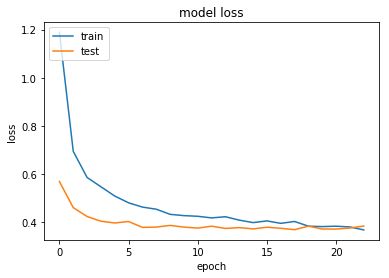

Fold 1 started at Thu Apr 11 09:49:32 2019
single model train loss: 
0.38395900543354733
single model validation loss: 
0.3979535531935388
single model dev loss: 
0.37816294517656357


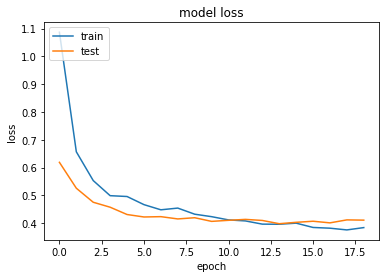

Fold 2 started at Thu Apr 11 09:49:50 2019
single model train loss: 
0.3584565118603084
single model validation loss: 
0.4140954433967707
single model dev loss: 
0.3843134449277452


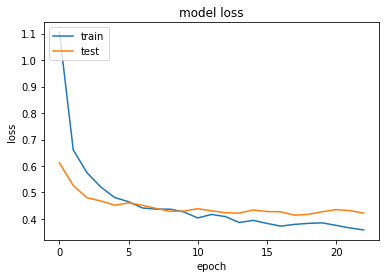

Fold 3 started at Thu Apr 11 09:50:15 2019
single model train loss: 
0.3713540606061864
single model validation loss: 
0.4156468147525876
single model dev loss: 
0.3846320943997639


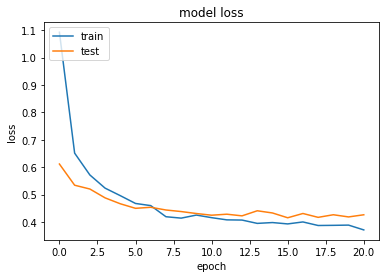

Fold 4 started at Thu Apr 11 09:50:39 2019
single model train loss: 
0.3990708255657443
single model validation loss: 
0.3465432994554694
single model dev loss: 
0.37567685866348594


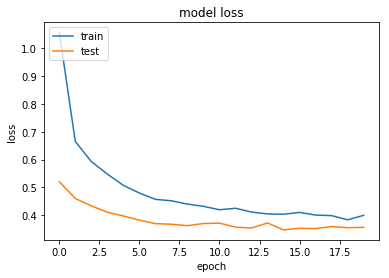

cv model accuracy: 
0.36452021115882277


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Fold 0 started at Thu Apr 11 09:51:03 2019
single model train loss: 
0.36045020309430137
single model validation loss: 
0.3582830362336239
single model dev loss: 
0.3885425421694959


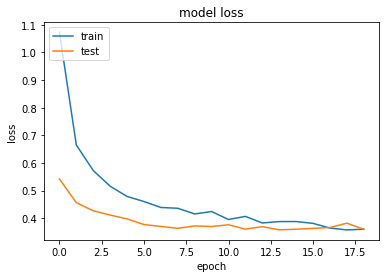

Fold 1 started at Thu Apr 11 09:51:25 2019
single model train loss: 
0.33146931561110893
single model validation loss: 
0.3984334203092313
single model dev loss: 
0.37855789529246114


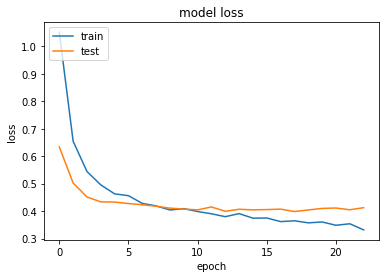

Fold 2 started at Thu Apr 11 09:51:48 2019
single model train loss: 
0.3734267565959729
single model validation loss: 
0.3954741680132869
single model dev loss: 
0.35622305289594913


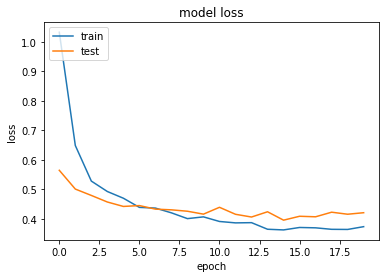

Fold 3 started at Thu Apr 11 09:52:11 2019
single model train loss: 
0.33365184512938034
single model validation loss: 
0.3980504694493341
single model dev loss: 
0.3613743015705165


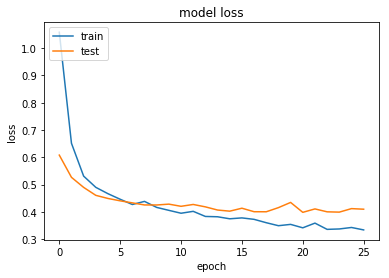

Fold 4 started at Thu Apr 11 09:52:40 2019
single model train loss: 
0.3741074494189686
single model validation loss: 
0.3410399892934948
single model dev loss: 
0.37112096738028283


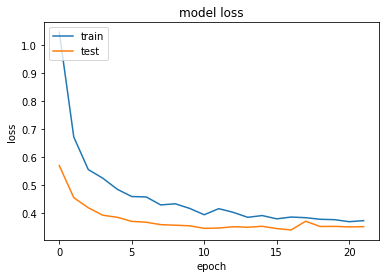

cv model accuracy: 
0.35199147708958967


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Fold 0 started at Thu Apr 11 09:53:09 2019
single model train loss: 
0.38595264216389835
single model validation loss: 
0.37229059350522525
single model dev loss: 
0.37580076568580295


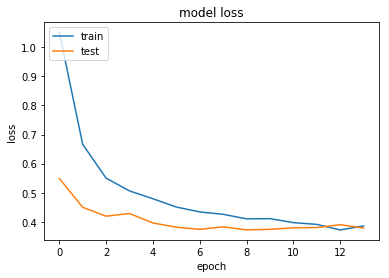

Fold 1 started at Thu Apr 11 09:53:27 2019
single model train loss: 
0.3613512554689299
single model validation loss: 
0.40420329702058594
single model dev loss: 
0.3728909668834805


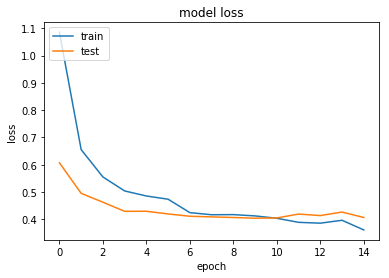

Fold 2 started at Thu Apr 11 09:53:45 2019
single model train loss: 
0.34586107008945866
single model validation loss: 
0.3961094632004977
single model dev loss: 
0.372253217185305


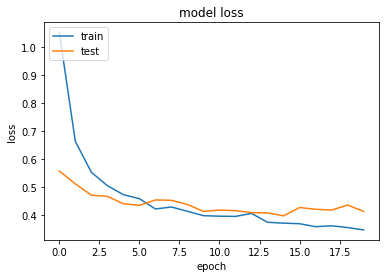

Fold 3 started at Thu Apr 11 09:54:10 2019
single model train loss: 
0.37207054036744636
single model validation loss: 
0.4182624381488685
single model dev loss: 
0.3785883595288341


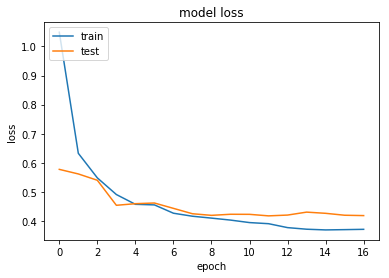

Fold 4 started at Thu Apr 11 09:54:33 2019
single model train loss: 
0.3982241909812998
single model validation loss: 
0.34124546022339997
single model dev loss: 
0.3901447946662455


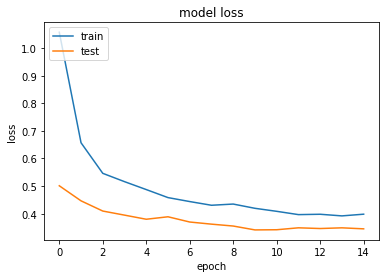

cv model accuracy: 
0.3644990339916169


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Fold 0 started at Thu Apr 11 09:54:57 2019
single model train loss: 
0.34450002561641646
single model validation loss: 
0.3614299200145497
single model dev loss: 
0.36365121449334326


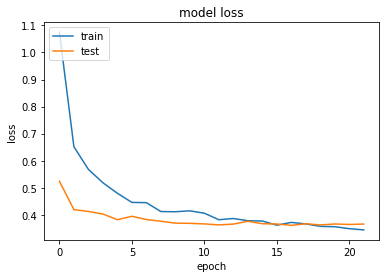

Fold 1 started at Thu Apr 11 09:55:26 2019
single model train loss: 
0.34567626433659204
single model validation loss: 
0.39882442728323514
single model dev loss: 
0.36660107819564147


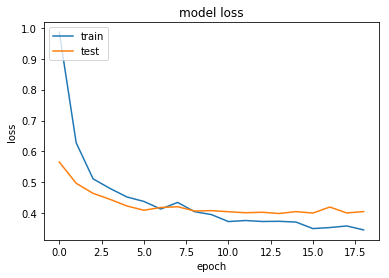

Fold 2 started at Thu Apr 11 09:55:51 2019
single model train loss: 
0.34914737745471625
single model validation loss: 
0.4012507096480768
single model dev loss: 
0.3892209215000403


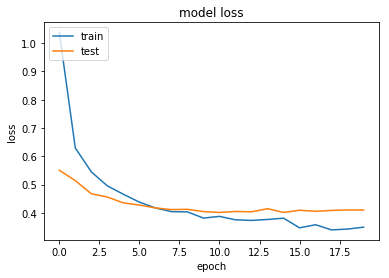

Fold 3 started at Thu Apr 11 09:56:18 2019
single model train loss: 
0.34399595366131447
single model validation loss: 
0.4044999523408214
single model dev loss: 
0.3607034223891335


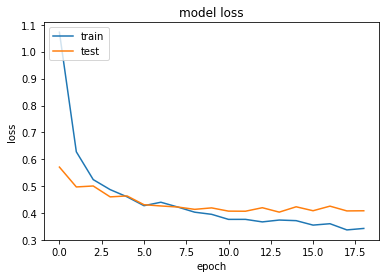

Fold 4 started at Thu Apr 11 09:56:45 2019
single model train loss: 
0.3638661895637159
single model validation loss: 
0.3339042986860734
single model dev loss: 
0.37695013776577563


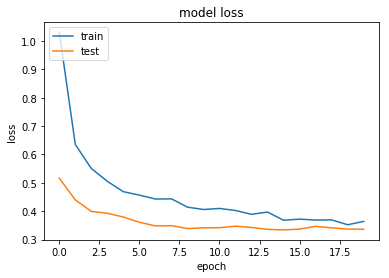

cv model accuracy: 
0.35752576726107377


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Fold 0 started at Thu Apr 11 09:57:17 2019
single model train loss: 
0.3847756954499438
single model validation loss: 
0.371696277890592
single model dev loss: 
0.35392140708922243


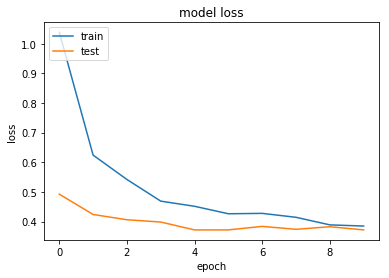

Fold 1 started at Thu Apr 11 09:57:36 2019
single model train loss: 
0.3402315874265719
single model validation loss: 
0.3807221391931288
single model dev loss: 
0.3742397969516531


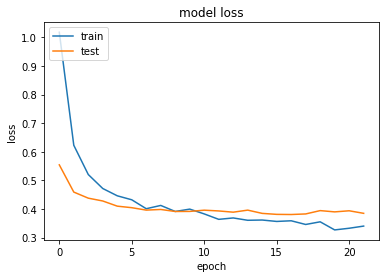

Fold 2 started at Thu Apr 11 09:58:06 2019
single model train loss: 
0.3516099735261491
single model validation loss: 
0.4055016302442349
single model dev loss: 
0.3719866981752755


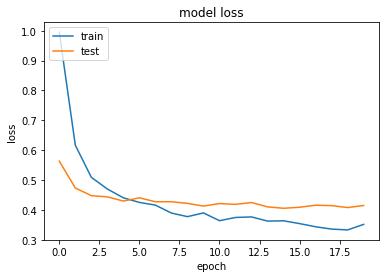

Fold 3 started at Thu Apr 11 09:58:36 2019
single model train loss: 
0.3289890951066284
single model validation loss: 
0.40628809367854146
single model dev loss: 
0.35942739792013345


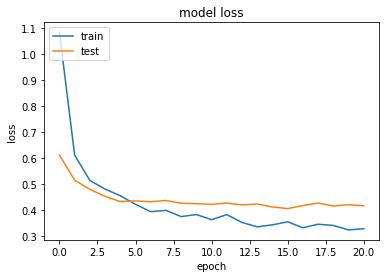

Fold 4 started at Thu Apr 11 09:59:07 2019
single model train loss: 
0.36490095130823275
single model validation loss: 
0.3083509684151609
single model dev loss: 
0.3831107147375052


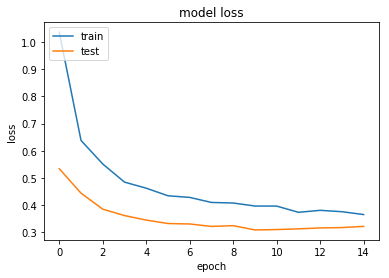

cv model accuracy: 
0.3507862276760863


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

Fold 0 started at Thu Apr 11 09:59:35 2019
single model train loss: 
0.3551286099643647
single model validation loss: 
0.3842781716644521
single model dev loss: 
0.38002626520058624


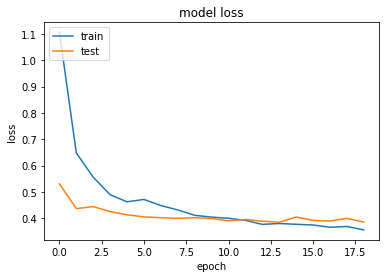

Fold 1 started at Thu Apr 11 10:00:05 2019
single model train loss: 
0.3414736256192002
single model validation loss: 
0.39912185875917033
single model dev loss: 
0.3986153194373833


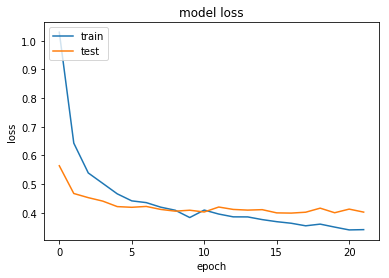

Fold 2 started at Thu Apr 11 10:00:38 2019
single model train loss: 
0.3539154555486596
single model validation loss: 
0.4297149076922181
single model dev loss: 
0.37690273626999765


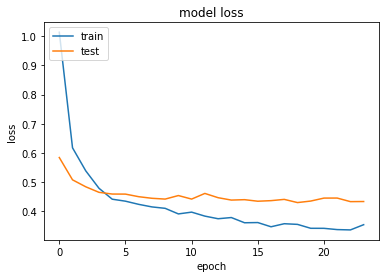

Fold 3 started at Thu Apr 11 10:01:14 2019
single model train loss: 
0.35243683923845703
single model validation loss: 
0.41556918817300226
single model dev loss: 
0.3721337268990478


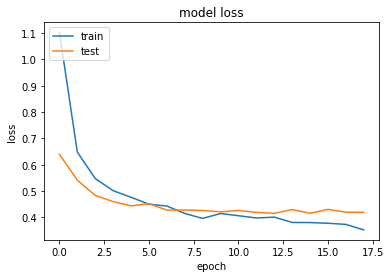

Fold 4 started at Thu Apr 11 10:01:45 2019
single model train loss: 
0.37089048629557647
single model validation loss: 
0.346392597097476
single model dev loss: 
0.3863672679080203


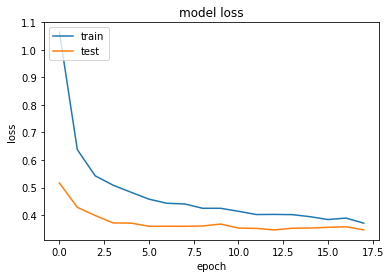

cv model accuracy: 
0.3668617760113768


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

In [23]:
for time_step in range(NUM_BERT_LAYERS):
    model_name = "mappedmlp_layer" + str(time_step)
    
    # Training and cross-validation
    num_batches = int(np.ceil(float(train_df.shape[0]) / batch_size))
    dummy_X = np.zeros(shape=(num_batches, 1))

    folds = KFold(n_splits=n_fold, shuffle=False, random_state=3)
    is_first_fold = True
    preds_train = list()
    preds_dev = None
    preds_test = None
    for fold_n, (train_batch_index, val_batch_index) in enumerate(folds.split(dummy_X)):
        # split training and validation data
        print('Fold', fold_n, 'started at', time.ctime())

        # train and validation data
        train_generator = data_generator(train_df, [train_pa_feats, train_pb_feats], embed_folder, "train_embed",
                                         batch_size, file_size, time_step, train_batch_index, return_label=True, shuffle=True)
        X_val, y_val = load_data(train_df, [train_pa_feats, train_pb_feats], embed_folder, "train_embed", batch_size, file_size,
                                 time_step, val_batch_index)
        # dev data
        num_dev_batches = int(np.ceil(float(dev_df.shape[0]) / batch_size))
        dev_generator = data_generator(dev_df, [dev_pa_feats, dev_pb_feats], embed_folder, "dev_embed", batch_size, file_size,
                                        time_step, np.arange(num_dev_batches), return_label=False)
        # test data
        num_test_batches = int(np.ceil(float(test_df.shape[0]) / batch_size))
        test_generator = data_generator(test_df, [test_pa_feats, test_pb_feats], embed_folder, "test_embed", batch_size, file_size,
                                        time_step, np.arange(num_test_batches), return_label=False)

        model, co = build_mapped_mlp_model(
            embed_dim, 1, extra_feature_dims, output_dim, model_dim, model1_dim, mlp_dim,
            mlp_depth=mlp_depth, embed_dropout=embed_dropout, drop_out=drop_out,
            gpu=gpu, return_customized_layers=return_customized_layers)

        adam = ko.Nadam()
        model.compile(adam, loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])

        early_stop = kc.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
        history = model.fit_generator(train_generator, steps_per_epoch=train_batch_index.shape[0], epochs=epochs,
                            validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)
        
        preds_train_tmp = model.predict(X_val)
        preds_dev_tmp = model.predict_generator(dev_generator, num_dev_batches)
        preds_test_tmp = model.predict_generator(test_generator, num_test_batches)
    
        print("single model train loss: ")
        print(history.history['loss'][-1])
        print("single model validation loss: ")
        print(measure_log_loss(y_val, preds_train_tmp))
        print("single model dev loss: ")
        print(measure_log_loss(dev_df['Label'].values, preds_dev_tmp))
    
        fig = plt.figure()
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        fig.savefig(model_name + '_lossplot.png')
        #plt.close(fig)
    
        if is_first_fold:
            preds_train.append(preds_train_tmp)
            preds_dev = preds_dev_tmp
            preds_test = preds_test_tmp
        else:
            preds_train.append(preds_train_tmp)
            preds_dev += preds_dev_tmp
            preds_test += preds_test_tmp
        
        is_first_fold = False

    preds_train = np.concatenate(preds_train)
    preds_dev /= n_fold
    preds_test /= n_fold
    print("cv model accuracy: ")
    print(measure_log_loss(dev_df['Label'].values, preds_dev))

    add_results(train_df, preds_train)
    add_results(dev_df, preds_dev)
    add_results(test_df, preds_test)
    train_file_name = model_name + "_train.csv"
    dev_file_name = model_name + "_dev.csv"
    test_file_name = model_name + "_test.csv"

    train_df.to_csv(train_file_name, index=False)
    dev_df.to_csv(dev_file_name, index=False)
    test_df.to_csv(test_file_name, index=False)

    drop_results(train_df)
    drop_results(dev_df)
    drop_results(test_df)